In [2]:
import numpy as np
import pandas as pd
from format_data import *
from plots import *

C:\Users\linab\AppData\Local\Temp\ipykernel_22188\795824496.py:3: RankWarning: Polyfit may be poorly conditioned
  from format_data import *


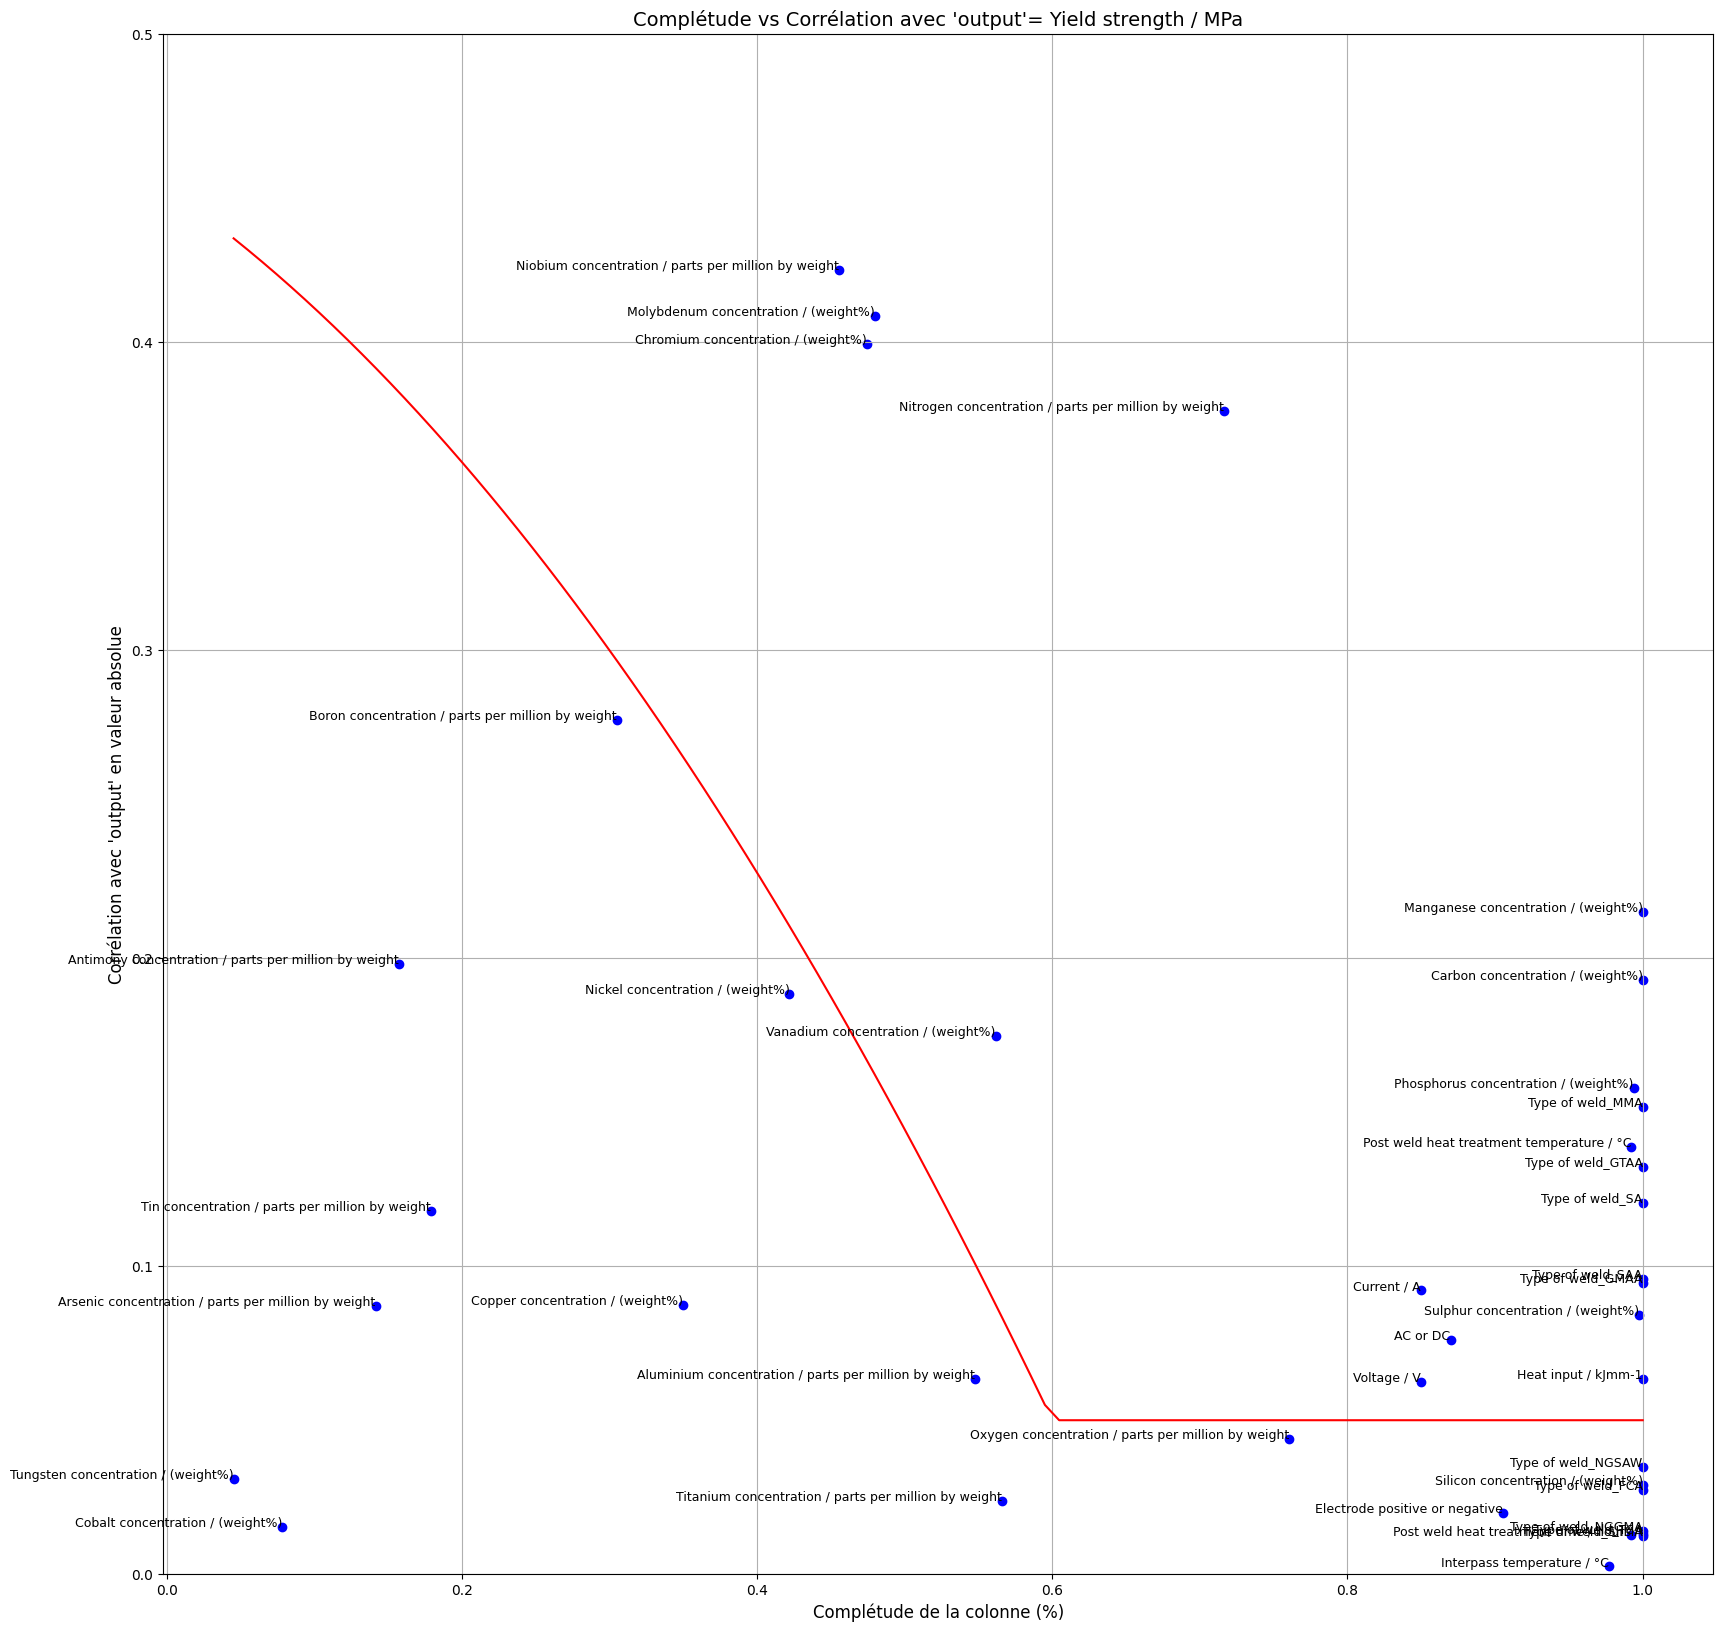

In [7]:
Db=pd.read_excel('table.xlsx', )
Db = Db.rename(columns={"Yield strength / MPa": 'output'})
features = list(set(Db.columns)-set(MECHANICAL_PROPERTIES))
Db=Db[features]
corr = get_corr(Db, 30)
features = plot_completeness_vs_corr(corr)

In [11]:
Db[features].to_excel('relvant_features.xlsx')